n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |    100 |             - |             -
     2 |      200 |    100 |  0.0060440674 |             f
     3 |      300 |    100 |  0.0037592606 |         ideal
     4 |      400 |    100 |  0.0468305977 |         ideal
     5 |      500 |    100 |  0.0025924574 |             f
     6 |      600 |    100 |  0.0027150941 |             f
     7 |      700 |    100 |  0.0022698128 |             f
     8 |      800 |    100 |  0.0036529727 |             f
     9 |      900 |    100 |  0.0022944092 |             f
    10 |     1000 |    100 |  0.0038922316 |             f
    11 |     1100 |    100 |  0.0024365384 |             f
    12 |     1200 |    100 |  0.0038884972 |             f
    13 |     1300 |    100 |  0.0025571051 |             f
    14 |     1400 |    100 |  0.0031376089 |             f
    15 |     1500 |    100 |  0.0024130303 |             f
    16 |     1600 |    100 |  0.0040478444 |            

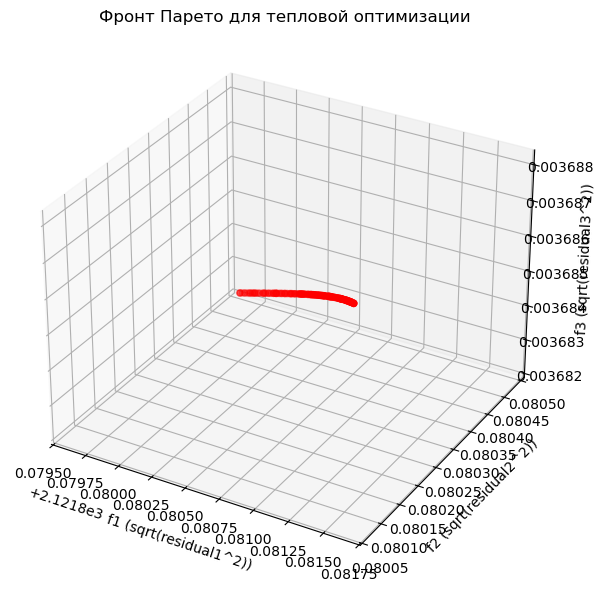

In [1]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import matplotlib.pyplot as plt

# 1. Определяем реалистичные параметры теплопередачи
Q = 1000.0         # мощность теплового потока, Вт
F = 1.0            # коэффициент формы (безразмерный)
c = 500.0          # удельная теплоемкость, Дж/(кг·K)
rho = 7800.0      # плотность материала, кг/м^3
a = 1e-5          # теплопроводность (диффузия), м^2/с
b = 0.01          # коэффициент потерь (аттенюации), 1/с
L = 0.05          # шаг расположения источников, м
l = 0.02          # смещение для второго набора источников, м

# Временные шаги и эталонный профиль T_prg (например, заданная температура)
n_time = 50
t = np.linspace(1.0, 1000.0, n_time)  # время в секундах
T_prg = 300.0 + 10.0 * np.sin(2 * np.pi * (t - 1) / (1000.0 - 1))  # пример эталонного температурного профиля

# Количество эталонных источников (n_ref)
n_ref = 5
ref_indices = np.arange(n_ref)  # 0,1,...,n_ref-1

class ThermalParetoProblem(Problem):
    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=3,
                         n_constr=0,
                         xl=np.array([0.001, 0.001]),  # нижние границы для [h, W] в метрах
                         xu=np.array([0.1,   0.1]))    # верхние границы для [h, W]

    def _evaluate(self, X, out, *args, **kwargs):
        # X.shape = (pop_size, 2)
        n_pop = X.shape[0]
        f1 = np.zeros(n_pop)
        f2 = np.zeros(n_pop)
        f3 = np.zeros(n_pop)

        # Перебираем популяцию
        for i in range(n_pop):
            h, W = X[i, 0], X[i, 1]

            # Предположим, что параметры теплопроводности или другие факторы зависят от h и W.
            # Для демонстрации добавим зависимость: изменим коэффициент b в зависимости от h.
            b_eff = b * (1 + 0.5 * np.exp(-h / 0.01))

            # Вычисляем сигналы от эталонных источников
            sum_ref = np.zeros_like(t)
            sum_sym = np.zeros_like(t)
            for k in ref_indices:
                dist_ref = 2 * k * L
                sum_ref += (2 * Q * F) / (c * rho * np.sqrt(4 * a * t)) * np.exp(-dist_ref**2 / (4 * a * t) - b_eff * t)
            for j in [-1, 1]:
                dist_sym = j * l
                sum_sym += (Q * F) / (c * rho * np.sqrt(4 * a * t)) * np.exp(-dist_sym**2 / (4 * a * t) - b_eff * t)

            # Функции целей: квадратные суммы отклонений
            residual1 = sum_ref - T_prg
            residual2 = sum_ref - sum_sym

            # Для третьей цели — производные по времени (аппроксимация разностями)
            dt = t[1] - t[0]
            d_ref = np.diff(sum_ref) / dt
            d_sym = np.diff(sum_sym) / dt
            residual3 = d_ref - d_sym

            f1[i] = np.sqrt(np.sum(residual1**2))
            f2[i] = np.sqrt(np.sum(residual2**2))
            f3[i] = np.sqrt(np.sum(residual3**2))

        out["F"] = np.column_stack([f1, f2, f3])


# 2. Настройка алгоритма NSGA-II
problem = ThermalParetoProblem()
algorithm = NSGA2(pop_size=100)

# 3. Запуск оптимизации
res = minimize(problem,
               algorithm,
               ('n_gen', 200),  # число поколений
               verbose=True,
               seed=42)

# 4. Извлекаем решения и отображаем фронт Парето
X_res = res.X       # решения по [h, W]
F_res = res.F       # соответствующие значения целей (f1, f2, f3)

# 5. Визуализация (3D-график) фронта Парето
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(F_res[:, 0], F_res[:, 1], F_res[:, 2], c='red', marker='o', s=20)
ax.set_xlabel('f1 (sqrt(residual1^2))')
ax.set_ylabel('f2 (sqrt(residual2^2))')
ax.set_zlabel('f3 (sqrt(residual3^2))')
ax.set_title('Фронт Парето для тепловой оптимизации')
plt.tight_layout()
plt.show()


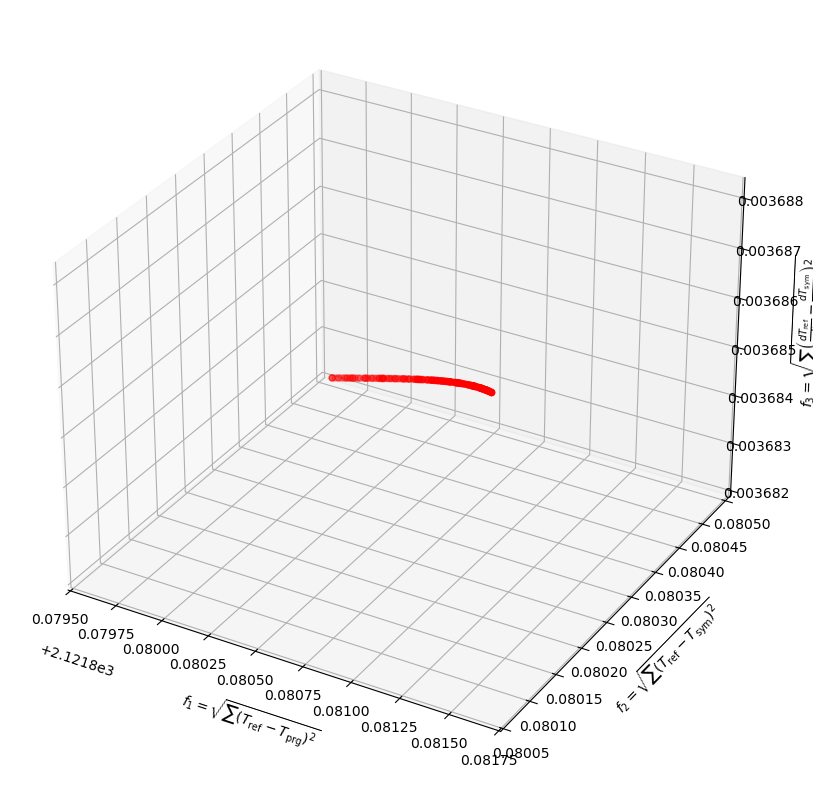

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # для 3D-графика

# 5. Визуализация (3D-график) фронта Парето с LaTeX-подписями
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(F_res[:, 0], F_res[:, 1], F_res[:, 2], c='red', marker='o', s=20)

# LaTeX-подписи осей
ax.set_xlabel(r'$f_1 = \sqrt{\sum (T_{\mathrm{ref}} - T_{\mathrm{prg}})^2}$', labelpad=10)
ax.set_ylabel(r'$f_2 = \sqrt{\sum (T_{\mathrm{ref}} - T_{\mathrm{sym}})^2}$', labelpad=10)
ax.set_zlabel(r'$f_3 = \sqrt{\sum \left( \frac{dT_{\mathrm{ref}}}{dt} - \frac{dT_{\mathrm{sym}}}{dt} \right)^2}$', labelpad=10)

# Заголовок
#ax.set_title('Фронт Парето для тепловой оптимизации', pad=20)

plt.tight_layout()
plt.savefig('tri_obj.pdf')
plt.show()


In [13]:
# single_objective_thermal_penalty.py

import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize

# 1. Физические параметры (реалистичные)
Q = 1000.0        # мощность теплового потока, Вт
F = 1.0           # коэффициент формы (безразмерный)
cp = 500.0        # суммарная теплоёмкость (c·ρ), Дж/(кг·K)
a = 1e-5          # теплопроводность (диффузия), м²/с
b = 0.01          # коэффициент потерь (аттенюации), 1/с
L = 0.05          # шаг расположения «эталонных» источников, м
l = 0.02          # смещение для «симметричных» источников, м

# 2. Временные узлы и эталонный профиль T_prg
n_time = 50
t = np.linspace(1.0, 1000.0, n_time)  
T_prg = 300.0 + 10.0 * np.sin(2 * np.pi * (t - 1) / (1000.0 - 1))

# 3. Количество «эталонных» источников
n_ref = 5
ref_indices = np.arange(n_ref)

# 4. Пороговые значения ограничений
T_err_avg_limit = 5.0    # среднеквадратичная ошибка ≤ 5 K
T_err_max_limit = 10.0   # макс. отклонение ≤ 10 K
V_sp_limit = 0.05        # макс. темп изменения ≤ 0.05 K/с

# 5. Коэффициент штрафа (пенализации) для нарушений ограничений
PENALTY_COEFF = 1e6


class ThermalPenaltyProblem(Problem):
    """
    Однокритериальная задача без явных ограничений:
    Цель — минимизировать f_total = f + PENALTY_COEFF * sum(max(0, g_i)),
    где g_i — три выражения, отвечающие исходным ограничениям.

    Переменные: h и W (толщина и ширина) в диапазоне [0.001, 0.1] м.
    """
    def __init__(self):
        super().__init__(
            n_var=2,        # h и W
            n_obj=1,        # одна функция (с учётом штрафов)
            n_constr=0,     # никаких явных ограничений (все через штраф)
            xl=np.array([0.001, 0.001]),  # мин h, W
            xu=np.array([0.1,   0.1])     # макс h, W
        )

    def _evaluate(self, X, out, *args, **kwargs):
        pop_size = X.shape[0]
        Fval = np.zeros(pop_size)

        for i in range(pop_size):
            h, W = X[i, 0], X[i, 1]

            # b_eff зависит от h (как раньше)
            b_eff = b * (1 + 0.5 * np.exp(-h / 0.01))

            # --- Вычисляем sum_ref(t) ---
            sum_ref = np.zeros_like(t)
            for k in ref_indices:
                dist_ref = 2 * k * L
                sum_ref += (
                    2 * Q * F * cp
                    / np.sqrt(4 * a * t)
                    * np.exp(-dist_ref**2 / (4 * a * t) - b_eff * t)
                )

            # --- Вычисляем sum_sym(t) ---
            sum_sym = np.zeros_like(t)
            for j in (-1, 1):
                dist_sym = j * l
                sum_sym += (
                    Q * F * cp
                    / np.sqrt(4 * a * t)
                    * np.exp(-dist_sym**2 / (4 * a * t) - b_eff * t)
                )

            # --- Целевая функция без штрафов ---
            residual_obj = sum_ref - sum_sym
            f_val = np.sqrt(np.sum(residual_obj**2))

            # --- Вычисляем «нарушения» ограничений g1, g2, g3 ---
            # g1: sqrt(sum (sum_ref - T_prg)^2) ≤ T_err_avg_limit
            residual_avg = sum_ref - T_prg
            g1 = np.sqrt(np.sum(residual_avg**2)) - T_err_avg_limit

            # g2: max_i |sum_ref(t_i) - T_prg(t_i)| ≤ T_err_max_limit
            g2 = np.max(np.abs(residual_avg)) - T_err_max_limit

            # g3: sqrt(sum ( d(sum_ref)/dt )^2) ≤ V_sp_limit
            dt = t[1] - t[0]
            d_ref = np.diff(sum_ref) / dt
            g3 = np.sqrt(np.sum(d_ref**2)) - V_sp_limit

            # Если g_i > 0, добавляем штраф
            penalty = 0.0
            for g in (g1, g2, g3):
                if g > 0:
                    penalty += PENALTY_COEFF * g

            Fval[i] = f_val + penalty

        out["F"] = Fval.reshape(-1, 1)


if __name__ == "__main__":
    # 6. Инициализация задачи и алгоритма DE
    problem = ThermalPenaltyProblem()
    algorithm = DE(pop_size=100)

    # 7. Запуск оптимизации
    res = minimize(
        problem,
        algorithm,
        ("n_gen", 200),
        seed=42,
        verbose=True
    )

    # 8. Результаты
    x_opt = res.X  # найденное [h, W]

    # Пересчитаем «точные» f, g1, g2, g3 для x_opt
    h_opt, W_opt = x_opt[0], x_opt[1]
    b_eff_opt = b * (1 + 0.5 * np.exp(-h_opt / 0.01))

    # sum_ref и sum_sym при оптимуме
    sum_ref_opt = np.zeros_like(t)
    for k in ref_indices:
        dist_ref = 2 * k * L
        sum_ref_opt += (
            2 * Q * F * cp
            / np.sqrt(4 * a * t)
            * np.exp(-dist_ref**2 / (4 * a * t) - b_eff_opt * t)
        )
    sum_sym_opt = np.zeros_like(t)
    for j in (-1, 1):
        dist_sym = j * l
        sum_sym_opt += (
            Q * F * cp
            / np.sqrt(4 * a * t)
            * np.exp(-dist_sym**2 / (4 * a * t) - b_eff_opt * t)
        )

    # Точное значение целевой f
    f_opt = np.sqrt(np.sum((sum_ref_opt - sum_sym_opt)**2))

    # Точные g1, g2, g3
    residual_avg_opt = sum_ref_opt - T_prg
    g1_opt = np.sqrt(np.sum(residual_avg_opt**2)) - T_err_avg_limit
    g2_opt = np.max(np.abs(residual_avg_opt)) - T_err_max_limit
    dt = t[1] - t[0]
    g3_opt = np.sqrt(np.sum((np.diff(sum_ref_opt) / dt)**2)) - V_sp_limit

    print("=== РЕЗУЛЬТАТ ОПТИМИЗАЦИИ ===")
    print(f"h_opt = {h_opt:.5f} м, W_opt = {W_opt:.5f} м")
    print(f"f_opt = {f_opt:.5e}")
    print(f"g1 (RMS error)     = {g1_opt:.5f}  (≤ 0 → OK)")
    print(f"g2 (max deviation) = {g2_opt:.5f}  (≤ 0 → OK)")
    print(f"g3 (rate limit)    = {g3_opt:.5f}  (≤ 0 → OK)")


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  3.232112E+14 |  3.212041E+14
     2 |      200 |  3.225257E+14 |  3.210878E+14
     3 |      300 |  3.221641E+14 |  3.210863E+14
     4 |      400 |  3.218340E+14 |  3.210862E+14
     5 |      500 |  3.215010E+14 |  3.210862E+14
     6 |      600 |  3.213185E+14 |  3.210862E+14
     7 |      700 |  3.212727E+14 |  3.210862E+14
     8 |      800 |  3.211379E+14 |  3.210862E+14
     9 |      900 |  3.211101E+14 |  3.210862E+14
    10 |     1000 |  3.210866E+14 |  3.210862E+14
    11 |     1100 |  3.210866E+14 |  3.210862E+14
    12 |     1200 |  3.210865E+14 |  3.210862E+14
    13 |     1300 |  3.210865E+14 |  3.210862E+14
    14 |     1400 |  3.210862E+14 |  3.210862E+14
    15 |     1500 |  3.210862E+14 |  3.210862E+14
    16 |     1600 |  3.210862E+14 |  3.210862E+14
    17 |     1700 |  3.210862E+14 |  3.210862E+14
    18 |     1800 |  3.210862E+14 |  3.210862E+14
    19 |     1900 |  3.210862E+14 |  3.210862E+14


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  3.232112E+14 |  3.212041E+14
     2 |      200 |  3.225257E+14 |  3.210878E+14
     3 |      300 |  3.221641E+14 |  3.210863E+14
     4 |      400 |  3.218340E+14 |  3.210862E+14
     5 |      500 |  3.215010E+14 |  3.210862E+14
     6 |      600 |  3.213185E+14 |  3.210862E+14
     7 |      700 |  3.212727E+14 |  3.210862E+14
     8 |      800 |  3.211379E+14 |  3.210862E+14
     9 |      900 |  3.211101E+14 |  3.210862E+14
    10 |     1000 |  3.210866E+14 |  3.210862E+14
    11 |     1100 |  3.210866E+14 |  3.210862E+14
    12 |     1200 |  3.210865E+14 |  3.210862E+14
    13 |     1300 |  3.210865E+14 |  3.210862E+14
    14 |     1400 |  3.210862E+14 |  3.210862E+14
    15 |     1500 |  3.210862E+14 |  3.210862E+14
    16 |     1600 |  3.210862E+14 |  3.210862E+14
    17 |     1700 |  3.210862E+14 |  3.210862E+14
    18 |     1800 |  3.210862E+14 |  3.210862E+14
    19 |     1900 |  3.210862E+14 |  3.210862E+14


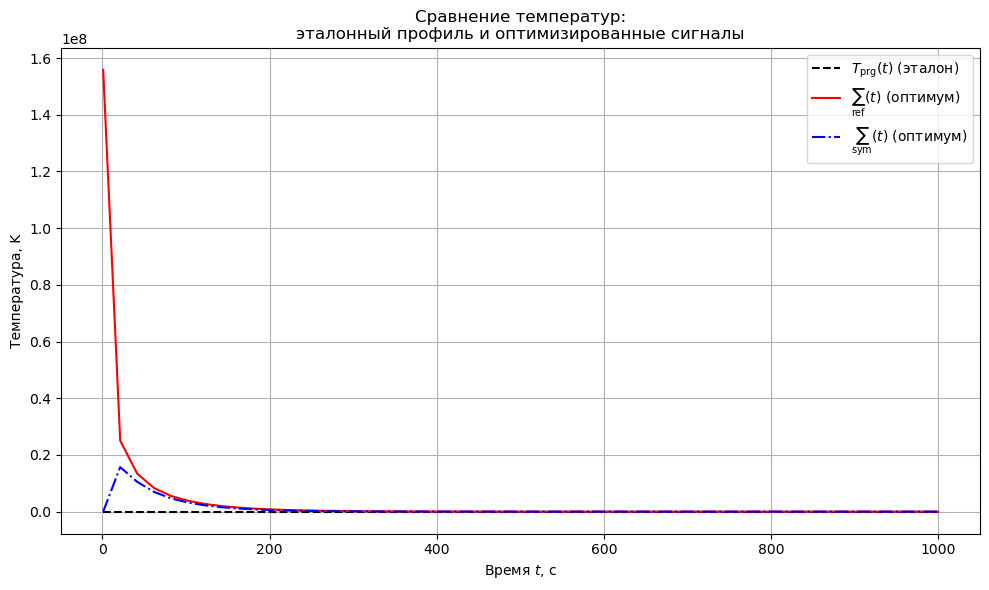

In [14]:
# single_objective_thermal_penalty_plot.py

import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize

# 1. Физические параметры (реалистичные)
Q = 1000.0        # мощность теплового потока, Вт
F = 1.0           # коэффициент формы (безразмерный)
cp = 500.0        # суммарная теплоёмкость (c·ρ), Дж/(кг·K)
a = 1e-5          # теплопроводность (диффузия), м²/с
b = 0.01          # коэффициент потерь (аттенюации), 1/с
L = 0.05          # шаг расположения «эталонных» источников, м
l = 0.02          # смещение для «симметричных» источников, м

# 2. Временные узлы и эталонный профиль T_prg
n_time = 50
t = np.linspace(1.0, 1000.0, n_time)
T_prg = 300.0 + 10.0 * np.sin(2 * np.pi * (t - 1) / (1000.0 - 1))

# 3. Количество «эталонных» источников
n_ref = 5
ref_indices = np.arange(n_ref)

# 4. Пороговые значения ограничений
T_err_avg_limit = 5.0    # среднеквадратичная ошибка ≤ 5 K
T_err_max_limit = 10.0   # макс. отклонение ≤ 10 K
V_sp_limit = 0.05        # макс. темп изменения ≤ 0.05 K/с

# 5. Коэффициент штрафа (пенализации) для нарушений ограничений
PENALTY_COEFF = 1e6


class ThermalPenaltyProblem(Problem):
    """
    Однокритериальная задача без явных ограничений:
    Цель — минимизировать f_total = f + PENALTY_COEFF * sum(max(0, g_i)),
    где g_i — три выражения, отвечающие исходным ограничениям.

    Переменные: h и W (толщина и ширина) в диапазоне [0.001, 0.1] м.
    """
    def __init__(self):
        super().__init__(
            n_var=2,        # h и W
            n_obj=1,        # одна функция (с учётом штрафов)
            n_constr=0,     # никаких явных ограничений (все через штраф)
            xl=np.array([0.001, 0.001]),  # мин h, W
            xu=np.array([0.1,   0.1])     # макс h, W
        )

    def _evaluate(self, X, out, *args, **kwargs):
        pop_size = X.shape[0]
        Fval = np.zeros(pop_size)

        for i in range(pop_size):
            h, W = X[i, 0], X[i, 1]

            # b_eff зависит от h
            b_eff = b * (1 + 0.5 * np.exp(-h / 0.01))

            # --- Вычисляем sum_ref(t) ---
            sum_ref = np.zeros_like(t)
            for k in ref_indices:
                dist_ref = 2 * k * L
                sum_ref += (
                    2 * Q * F * cp
                    / np.sqrt(4 * a * t)
                    * np.exp(-dist_ref**2 / (4 * a * t) - b_eff * t)
                )

            # --- Вычисляем sum_sym(t) ---
            sum_sym = np.zeros_like(t)
            for j in (-1, 1):
                dist_sym = j * l
                sum_sym += (
                    Q * F * cp
                    / np.sqrt(4 * a * t)
                    * np.exp(-dist_sym**2 / (4 * a * t) - b_eff * t)
                )

            # --- Целевая функция без штрафов ---
            residual_obj = sum_ref - sum_sym
            f_val = np.sqrt(np.sum(residual_obj**2))

            # --- Вычисляем «нарушения» ограничений g1, g2, g3 ---
            residual_avg = sum_ref - T_prg
            g1 = np.sqrt(np.sum(residual_avg**2)) - T_err_avg_limit
            g2 = np.max(np.abs(residual_avg)) - T_err_max_limit
            dt = t[1] - t[0]
            d_ref = np.diff(sum_ref) / dt
            g3 = np.sqrt(np.sum(d_ref**2)) - V_sp_limit

            # Если g_i > 0, добавляем штраф
            penalty = 0.0
            for g in (g1, g2, g3):
                if g > 0:
                    penalty += PENALTY_COEFF * g

            Fval[i] = f_val + penalty

        out["F"] = Fval.reshape(-1, 1)


if __name__ == "__main__":
    # 6. Инициализация задачи и алгоритма DE
    problem = ThermalPenaltyProblem()
    algorithm = DE(pop_size=100)

    # 7. Запуск оптимизации
    res = minimize(
        problem,
        algorithm,
        ("n_gen", 200),
        seed=42,
        verbose=True
    )

    # 8. Результаты
    x_opt = res.X  # найденное [h, W]
    h_opt, W_opt = x_opt[0], x_opt[1]
    b_eff_opt = b * (1 + 0.5 * np.exp(-h_opt / 0.01))

    # --- Пересчёт «чистых» sum_ref и sum_sym для x_opt ---
    sum_ref_opt = np.zeros_like(t)
    for k in ref_indices:
        dist_ref = 2 * k * L
        sum_ref_opt += (
            2 * Q * F * cp
            / np.sqrt(4 * a * t)
            * np.exp(-dist_ref**2 / (4 * a * t) - b_eff_opt * t)
        )
    sum_sym_opt = np.zeros_like(t)
    for j in (-1, 1):
        dist_sym = j * l
        sum_sym_opt += (
            Q * F * cp
            / np.sqrt(4 * a * t)
            * np.exp(-dist_sym**2 / (4 * a * t) - b_eff_opt * t)
        )

    # Точное значение целевой f
    f_opt = np.sqrt(np.sum((sum_ref_opt - sum_sym_opt)**2))

    # Точные g1, g2, g3
    residual_avg_opt = sum_ref_opt - T_prg
    g1_opt = np.sqrt(np.sum(residual_avg_opt**2)) - T_err_avg_limit
    g2_opt = np.max(np.abs(residual_avg_opt)) - T_err_max_limit
    dt = t[1] - t[0]
    g3_opt = np.sqrt(np.sum((np.diff(sum_ref_opt) / dt)**2)) - V_sp_limit

    print("=== РЕЗУЛЬТАТ ОПТИМИЗАЦИИ ===")
    print(f"h_opt = {h_opt:.5f} м, W_opt = {W_opt:.5f} м")
    print(f"f_opt = {f_opt:.5e}")
    print(f"g1 (RMS error)     = {g1_opt:.5f}  (≤ 0 → OK)")
    print(f"g2 (max deviation) = {g2_opt:.5f}  (≤ 0 → OK)")
    print(f"g3 (rate limit)    = {g3_opt:.5f}  (≤ 0 → OK)")

    # 9. Построение графиков
    plt.figure(figsize=(8, 6))

    # 9.1. График температурных профилей: эталон vs sum_ref_opt vs sum_sym_opt
    #plt.plot(t, T_prg,  'k--', label=r'$T_{\mathrm{prg}}(t)$ (эталон)')
    plt.plot(t, sum_ref_opt, 'r-',  label=r'$\sum_{\mathrm{ref}}(t)$ (оптимум)')
    #plt.plot(t, sum_sym_opt, 'b-.', label=r'$\sum_{\mathrm{sym}}(t)$ (оптимум)')
    plt.xlabel('Время $t$, с')
    plt.ylabel('Температура, K')
    plt.title('Сравнение температур:\nэталонный профиль и оптимизированные сигналы')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  5.430311E+09 |  4.843407E+09
     2 |      200 |  5.225393E+09 |  4.813884E+09
     3 |      300 |  5.120943E+09 |  4.813493E+09
     4 |      400 |  5.025783E+09 |  4.813456E+09
     5 |      500 |  4.928585E+09 |  4.813454E+09
     6 |      600 |  4.876815E+09 |  4.813454E+09
     7 |      700 |  4.863637E+09 |  4.813454E+09
     8 |      800 |  4.827701E+09 |  4.813454E+09
     9 |      900 |  4.820473E+09 |  4.813454E+09
    10 |     1000 |  4.813577E+09 |  4.813454E+09
    11 |     1100 |  4.813484E+09 |  4.813454E+09
    12 |     1200 |  4.813455E+09 |  4.813454E+09
    13 |     1300 |  4.813455E+09 |  4.813454E+09
    14 |     1400 |  4.813454E+09 |  4.813454E+09
    15 |     1500 |  4.813454E+09 |  4.813454E+09
    16 |     1600 |  4.813454E+09 |  4.813454E+09
    17 |     1700 |  4.813454E+09 |  4.813454E+09
    18 |     1800 |  4.813454E+09 |  4.813454E+09
    19 |     1900 |  4.813454E+09 |  4.813454E+09


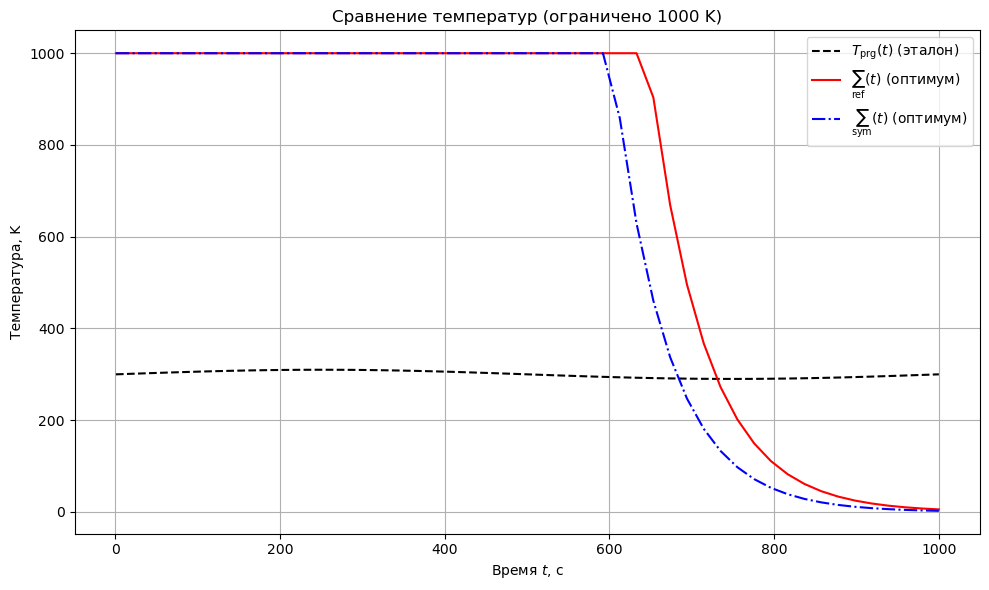

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize

# 1. Физические параметры (реалистичные)
Q = 1000.0        # мощность теплового потока, Вт
F = 1.0           # коэффициент формы (безразмерный)
cp = 500.0        # суммарная теплоёмкость (c·ρ), Дж/(кг·K)
a = 1e-5          # теплопроводность (диффузия), м²/с
b = 0.01          # коэффициент потерь (аттенюации), 1/с
L = 0.05          # шаг расположения «эталонных» источников, м
l = 0.02          # смещение для «симметричных» источников, м

# 2. Временные узлы и эталонный профиль T_prg (ограничить значение до 1000 K)
n_time = 50
t = np.linspace(1.0, 1000.0, n_time)
T_prg = 300.0 + 10.0 * np.sin(2 * np.pi * (t - 1) / (1000.0 - 1))
T_prg = np.minimum(T_prg, 1000.0)

# 3. Количество «эталонных» источников
n_ref = 5
ref_indices = np.arange(n_ref)

# 4. Пороговые значения ограничений
T_err_avg_limit = 5.0    # среднеквадратичная ошибка ≤ 5 K
T_err_max_limit = 10.0   # макс. отклонение ≤ 10 K
V_sp_limit = 0.05        # макс. темп изменения ≤ 0.05 K/с

# 5. Коэффициент штрафа (пенализации) для нарушений ограничений
PENALTY_COEFF = 1e6


class ThermalPenaltyProblem(Problem):
    """
    Однокритериальная задача без явных ограничений:
    Цель — минимизировать f_total = f + PENALTY_COEFF * sum(max(0, g_i)),
    где g_i — три выражения, отвечающие исходным ограничениям.

    Переменные: h и W (толщина и ширина) в диапазоне [0.001, 0.1] м.
    """
    def __init__(self):
        super().__init__(
            n_var=2,        # h и W
            n_obj=1,        # одна функция (с учётом штрафов)
            n_constr=0,     # никаких явных ограничений (все через штраф)
            xl=np.array([0.001, 0.001]),  # мин h, W
            xu=np.array([0.1,   0.1])     # макс h, W
        )

    def _evaluate(self, X, out, *args, **kwargs):
        pop_size = X.shape[0]
        Fval = np.zeros(pop_size)

        for i in range(pop_size):
            h, W = X[i, 0], X[i, 1]

            # b_eff зависит от h
            b_eff = b * (1 + 0.5 * np.exp(-h / 0.01))

            # --- Вычисляем sum_ref(t) и ограничиваем до 1000 K ---
            sum_ref = np.zeros_like(t)
            for k in ref_indices:
                dist_ref = 2 * k * L
                sum_ref += (
                    2 * Q * F * cp
                    / np.sqrt(4 * a * t)
                    * np.exp(-dist_ref**2 / (4 * a * t) - b_eff * t)
                )
            sum_ref = np.minimum(sum_ref, 1000.0)

            # --- Вычисляем sum_sym(t) и ограничиваем до 1000 K ---
            sum_sym = np.zeros_like(t)
            for j in (-1, 1):
                dist_sym = j * l
                sum_sym += (
                    Q * F * cp
                    / np.sqrt(4 * a * t)
                    * np.exp(-dist_sym**2 / (4 * a * t) - b_eff * t)
                )
            sum_sym = np.minimum(sum_sym, 1000.0)

            # --- Целевая функция без штрафов ---
            residual_obj = sum_ref - sum_sym
            f_val = np.sqrt(np.sum(residual_obj**2))

            # --- Вычисляем «нарушения» ограничений g1, g2, g3 ---
            residual_avg = sum_ref - T_prg
            g1 = np.sqrt(np.sum(residual_avg**2)) - T_err_avg_limit
            g2 = np.max(np.abs(residual_avg)) - T_err_max_limit
            dt = t[1] - t[0]
            d_ref = np.diff(sum_ref) / dt
            g3 = np.sqrt(np.sum(d_ref**2)) - V_sp_limit

            # Если g_i > 0, добавляем штраф
            penalty = 0.0
            for g in (g1, g2, g3):
                if g > 0:
                    penalty += PENALTY_COEFF * g

            Fval[i] = f_val + penalty

        out["F"] = Fval.reshape(-1, 1)


# Запуск оптимизации (без if __name__...)
problem = ThermalPenaltyProblem()
algorithm = DE(pop_size=100)

res = minimize(
    problem,
    algorithm,
    ("n_gen", 200),
    seed=42,
    verbose=True
)

# Результаты
x_opt = res.X
h_opt, W_opt = x_opt[0], x_opt[1]
b_eff_opt = b * (1 + 0.5 * np.exp(-h_opt / 0.01))

# --- Пересчёт «чистых» sum_ref и sum_sym для x_opt с ограничением до 1000 K ---
sum_ref_opt = np.zeros_like(t)
for k in ref_indices:
    dist_ref = 2 * k * L
    sum_ref_opt += (
        2 * Q * F * cp
        / np.sqrt(4 * a * t)
        * np.exp(-dist_ref**2 / (4 * a * t) - b_eff_opt * t)
    )
sum_ref_opt = np.minimum(sum_ref_opt, 1000.0)

sum_sym_opt = np.zeros_like(t)
for j in (-1, 1):
    dist_sym = j * l
    sum_sym_opt += (
        Q * F * cp
        / np.sqrt(4 * a * t)
        * np.exp(-dist_sym**2 / (4 * a * t) - b_eff_opt * t)
    )
sum_sym_opt = np.minimum(sum_sym_opt, 1000.0)

# Точное значение целевой f
f_opt = np.sqrt(np.sum((sum_ref_opt - sum_sym_opt)**2))

# Точные g1, g2, g3
residual_avg_opt = sum_ref_opt - T_prg
g1_opt = np.sqrt(np.sum(residual_avg_opt**2)) - T_err_avg_limit
g2_opt = np.max(np.abs(residual_avg_opt)) - T_err_max_limit
dt = t[1] - t[0]
g3_opt = np.sqrt(np.sum((np.diff(sum_ref_opt) / dt)**2)) - V_sp_limit

print("=== РЕЗУЛЬТАТ ОПТИМИЗАЦИИ ===")
print(f"h_opt = {h_opt:.5f} м, W_opt = {W_opt:.5f} м")
print(f"f_opt = {f_opt:.5e}")
print(f"g1 (RMS error)     = {g1_opt:.5f}  (≤ 0 → OK)")
print(f"g2 (max deviation) = {g2_opt:.5f}  (≤ 0 → OK)")
print(f"g3 (rate limit)    = {g3_opt:.5f}  (≤ 0 → OK)")

# Построение графиков
plt.figure(figsize=(10, 6))

# Температурные профили: эталон vs sum_ref_opt vs sum_sym_opt
plt.plot(t, T_prg,      'k--', label=r'$T_{\mathrm{prg}}(t)$ (эталон)')
plt.plot(t, sum_ref_opt, 'r-',  label=r'$\sum_{\mathrm{ref}}(t)$ (оптимум)')
plt.plot(t, sum_sym_opt, 'b-.', label=r'$\sum_{\mathrm{sym}}(t)$ (оптимум)')
plt.xlabel('Время $t$, с')
plt.ylabel('Температура, K')
plt.title('Сравнение температур (ограничено 1000 K)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


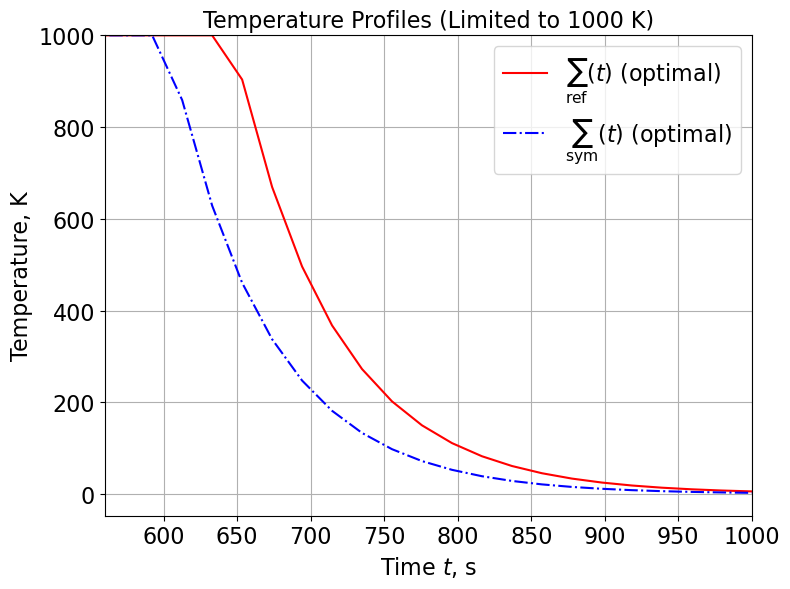

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot temperature profiles
#plt.plot(t, T_prg,       'k--', label=r'$T_{\mathrm{prg}}(t)$ (target)')
plt.plot(t, sum_ref_opt, 'r-',  label=r'$\sum_{\mathrm{ref}}(t)$ (optimal)')
plt.plot(t, sum_sym_opt, 'b-.', label=r'$\sum_{\mathrm{sym}}(t)$ (optimal)')

# Axis labels and title in English
plt.xlabel('Time $t$, s', fontsize=16)
plt.ylabel('Temperature, K', fontsize=16)
plt.title('Temperature Profiles (Limited to 1000 K)', fontsize=16)

# Set axis limits
plt.xlim(560, 1000)
plt.ylim(None, 1000)  # Optional: set y-limit if needed

# Style
plt.legend(fontsize=16)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('single_obj.pdf')
plt.show()


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

# ——————————————
# 1. ФИЗИЧЕСКИЕ ПАРАМЕТРЫ
# ——————————————
Q = 1000.0        # мощность теплового потока, Вт
F = 1.0           # коэффициент формы (безразмерный)
cp = 500.0        # суммарная теплоёмкость (c·ρ), Дж/(кг·K)
a = 1e-5          # теплопроводная диффузия, м²/с
b = 0.01          # коэффициент аттенюации, 1/с
L = 0.05          # шаг расположения «эталонных» источников, м
l = 0.02          # смещение для «симметричных» источников, м

# ——————————————
# 2. ВРЕМЕННЫЕ УЗЛЫ И ЭТАЛОННЫЙ ПРОФИЛЬ
# ——————————————
n_time = 50
t = np.linspace(1.0, 1000.0, n_time)  # интервал [1, 1000] с, n_time точек

# Пример эталонного профиля (300 K ± 10 K)
T_prg = 300.0 + 10.0 * np.sin(2 * np.pi * (t - 1) / (1000.0 - 1))

# ——————————————
# 3. «ЭТАЛОННЫЕ» И «СИММЕТРИЧНЫЕ» ИСТОЧНИКИ
# ——————————————
n_ref = 5
ref_indices = np.arange(n_ref)  # [0,1,2,3,4]

# ——————————————
# 4. ПАРАМЕТР ОГРАНИЧЕНИЯ СКОРОСТИ ИЗМЕНЕНИЯ
# ——————————————
V_sp_limit = 0.05   # ограничение: sqrt(sum((sum_ref(t_i) - sum_ref(t_{i-1}))^2)) ≤ V_sp_limit


class ThermalParetoProblem(Problem):
    """
    Многокритериальная задача:
      1) f1 = sqrt(sum_i (sum_ref(t_i) - T_prg(t_i))^2) -> min
      2) f2 = sqrt(sum_i (sum_ref(t_i) - sum_sym(t_i))^2) -> min
    Ограничение:
      g1 = sqrt(sum_{i=1..n_time-1} (sum_ref(t_i) - sum_ref(t_{i-1}))^2) - V_sp_limit ≤ 0

    Переменные: h и W (толщина и ширина) ∈ [0.001, 0.1] м.
    """
    def __init__(self):
        super().__init__(
            n_var=2,        # две проектные величины: h, W
            n_obj=2,        # две целевые функции (f1, f2)
            n_constr=1,     # одно неравенство-ограничение (g1 ≤ 0)
            xl=np.array([0.001, 0.001]),  # min h, W
            xu=np.array([0.1,   0.1])     # max h, W
        )

    def _evaluate(self, X, out, *args, **kwargs):
        pop_size = X.shape[0]

        f1 = np.zeros(pop_size)
        f2 = np.zeros(pop_size)
        g1 = np.zeros(pop_size)

        for i in range(pop_size):
            h, W = X[i, 0], X[i, 1]

            # b_eff зависит от h (аналогично предыдущим примерам)
            b_eff = b * (1 + 0.5 * np.exp(-h / 0.01))

            # Считаем суммарный сигнал от «эталонных» источников
            sum_ref = np.zeros_like(t)
            for k in ref_indices:
                dist_ref = 2 * k * L
                sum_ref += (
                    2 * Q * F * cp
                    / np.sqrt(4 * a * t)
                    * np.exp(-dist_ref**2 / (4 * a * t) - b_eff * t)
                )

            # Считаем суммарный сигнал от «симметричных» источников
            sum_sym = np.zeros_like(t)
            for j in (-1, 1):
                dist_sym = j * l
                sum_sym += (
                    Q * F * cp
                    / np.sqrt(4 * a * t)
                    * np.exp(-dist_sym**2 / (4 * a * t) - b_eff * t)
                )

            # Целевая 1: f1 = ||sum_ref(t) - T_prg(t)||₂
            residual1 = sum_ref - T_prg
            f1[i] = np.sqrt(np.sum(residual1**2))

            # Целевая 2: f2 = ||sum_ref(t) - sum_sym(t)||₂
            residual2 = sum_ref - sum_sym
            f2[i] = np.sqrt(np.sum(residual2**2))

            # Ограничение: скорость изменения sum_ref
            dt = t[1] - t[0]
            d_ref = np.diff(sum_ref) / dt
            g1[i] = np.sqrt(np.sum(d_ref**2)) - V_sp_limit

        out["F"] = np.column_stack([f1, f2])
        out["G"] = g1.reshape(-1, 1)  # формат (pop_size, n_constr)


# ——————————————
# 5. МНОГОКРИТЕРИАЛЬНАЯ ОПТИМИЗАЦИЯ (NSGA2)
# ——————————————
problem = ThermalParetoProblem()
algorithm = NSGA2(pop_size=100)

res = minimize(
    problem,
    algorithm,
    ("n_gen", 200),
    verbose=True,
    seed=42
)

# ——————————————
# 6. ИЗВЛЕЧЕНИЕ И ВИЗУАЛИЗАЦИЯ ФРОНТА ПАРЕТО
# ——————————————
F_res = res.F  # массив размером (n_points, 2): [f1, f2] для каждого недоминируемого решения

# 2D-график Pareto front (f1 vs f2)
plt.figure(figsize=(8, 6))
plt.scatter(F_res[:, 0], F_res[:, 1], c='red', s=20)
plt.xlabel(r'$f_1 = \sqrt{\sum_i \bigl(\sum_{\mathrm{ref}}(t_i) - T_{\mathrm{prg}}(t_i)\bigr)^2}$', fontsize=14)
plt.ylabel(r'$f_2 = \sqrt{\sum_i \bigl(\sum_{\mathrm{ref}}(t_i) - \sum_{\mathrm{sym}}(t_i)\bigr)^2}$', fontsize=14)
plt.title('Pareto Front for Thermal Optimization', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  6.357344E+06 |  6.369321E+06 |             - |             -
     2 |      200 |      1 |  6.357344E+06 |  6.357390E+06 |             - |             -
     3 |      300 |      1 |  6.357344E+06 |  6.357349E+06 |             - |             -
     4 |      400 |      1 |  6.357344E+06 |  6.357345E+06 |             - |             -
     5 |      500 |      1 |  6.357344E+06 |  6.357344E+06 |             - |             -
     6 |      600 |      1 |  6.357344E+06 |  6.357344E+06 |             - |             -
     7 |      700 |      1 |  6.357344E+06 |  6.357344E+06 |             - |             -
     8 |      800 |      1 |  6.357344E+06 |  6.357344E+06 |             - |             -
     9 |      900 |      1 |  6.357344E+06 |  6.357344E+06 |             - |             -
    10 |     1000 |      1 |  6.357344E+06 |  6.357344E+06 |             - |             -

TypeError: 'NoneType' object is not subscriptable

<Figure size 800x600 with 0 Axes>

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |    100 |             - |             -
     2 |      200 |    100 |  0.0059922850 |             f
     3 |      300 |    100 |  0.0079300263 |             f
     4 |      400 |    100 |  0.0392181950 |         ideal
     5 |      500 |    100 |  0.0082014948 |         ideal
     6 |      600 |    100 |  0.0035693488 |         ideal
     7 |      700 |    100 |  0.0031444874 |             f
     8 |      800 |    100 |  0.0019105173 |             f
     9 |      900 |    100 |  0.0038748294 |             f
    10 |     1000 |    100 |  0.0023687654 |             f
    11 |     1100 |    100 |  0.0036966511 |             f
    12 |     1200 |    100 |  0.0023817870 |             f
    13 |     1300 |    100 |  0.0033659323 |             f
    14 |     1400 |    100 |  0.0019934797 |             f
    15 |     1500 |    100 |  0.0040770027 |             f
    16 |     1600 |    100 |  0.0028303992 |            

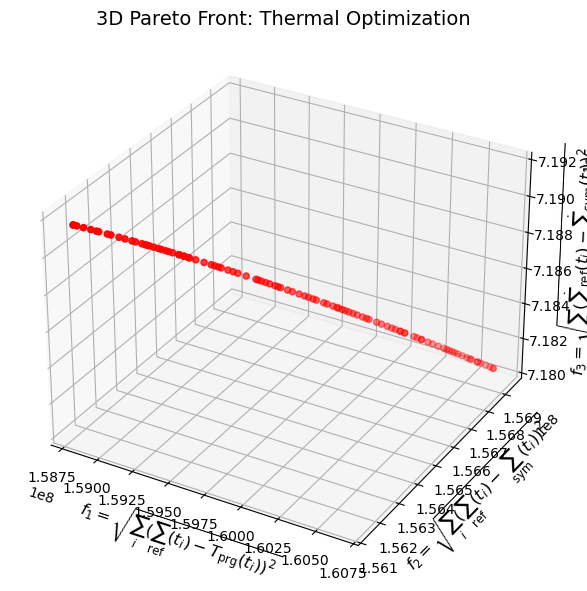

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

# ——————————————
# 1. ФИЗИЧЕСКИЕ ПАРАМЕТРЫ
# ——————————————
Q = 1000.0        # мощность теплового потока, Вт
F = 1.0           # коэффициент формы (безразмерный)
cp = 500.0        # суммарная теплоёмкость (c·ρ), Дж/(кг·K)
a = 1e-5          # теплопроводная диффузия, м²/с
b = 0.01          # коэффициент аттенюации, 1/с
L = 0.05          # шаг расположения «эталонных» источников, м
l = 0.02          # смещение для «симметричных» источников, м

# ——————————————
# 2. ВРЕМЕННЫЕ УЗЛЫ И ЭТАЛОННЫЙ ПРОФИЛЬ
# ——————————————
n_time = 50
t = np.linspace(1.0, 1000.0, n_time)  # интервал [1, 1000] с, n_time точек

# Пример эталонного профиля (300 K ± 10 K)
T_prg = 300.0 + 10.0 * np.sin(2 * np.pi * (t - 1) / (1000.0 - 1))

# ——————————————
# 3. «ЭТАЛОННЫЕ» И «СИММЕТРИЧНЫЕ» ИСТОЧНИКИ
# ——————————————
n_ref = 5
ref_indices = np.arange(n_ref)  # [0,1,2,3,4]

class ThermalParetoProblem(Problem):
    """
    Многокритериальная задача с тремя целями:
      f1 = sqrt(sum_i (sum_ref(t_i) - T_prg(t_i))^2)
      f2 = sqrt(sum_i (sum_ref(t_i) - sum_sym(t_i))^2)
      f3 = sqrt(sum_i (d_ref(t_i) - d_sym(t_i))^2)

    Переменные: h и W (толщина и ширина) ∈ [0.001, 0.1] м.
    """
    def __init__(self):
        super().__init__(
            n_var=2,        # h и W
            n_obj=3,        # три целевые функции
            n_constr=0,     # без явных ограничений
            xl=np.array([0.001, 0.001]),  # min h, W
            xu=np.array([0.1,   0.1])     # max h, W
        )

    def _evaluate(self, X, out, *args, **kwargs):
        pop_size = X.shape[0]

        f1 = np.zeros(pop_size)
        f2 = np.zeros(pop_size)
        f3 = np.zeros(pop_size)

        for i in range(pop_size):
            h, W = X[i, 0], X[i, 1]

            # b_eff зависит от h
            b_eff = b * (1 + 0.5 * np.exp(-h / 0.01))

            # Суммарный сигнал от «эталонных» источников
            sum_ref = np.zeros_like(t)
            for k in ref_indices:
                dist_ref = 2 * k * L
                sum_ref += (
                    2 * Q * F * cp
                    / np.sqrt(4 * a * t)
                    * np.exp(-dist_ref**2 / (4 * a * t) - b_eff * t)
                )

            # Суммарный сигнал от «симметричных» источников
            sum_sym = np.zeros_like(t)
            for j in (-1, 1):
                dist_sym = j * l
                sum_sym += (
                    Q * F * cp
                    / np.sqrt(4 * a * t)
                    * np.exp(-dist_sym**2 / (4 * a * t) - b_eff * t)
                )

            # 1) f1 = ||sum_ref - T_prg||₂
            residual1 = sum_ref - T_prg
            f1[i] = np.sqrt(np.sum(residual1**2))

            # 2) f2 = ||sum_ref - sum_sym||₂
            residual2 = sum_ref - sum_sym
            f2[i] = np.sqrt(np.sum(residual2**2))

            # 3) f3 = ||d_ref - d_sym||₂, где d_ref = d(sum_ref)/dt, d_sym = d(sum_sym)/dt
            dt = t[1] - t[0]
            d_ref  = np.diff(sum_ref)  / dt
            d_sym  = np.diff(sum_sym)  / dt
            residual3 = d_ref - d_sym
            f3[i] = np.sqrt(np.sum(residual3**2))

        out["F"] = np.column_stack([f1, f2, f3])


# ——————————————
# 4. МНОГОКРИТЕРИАЛЬНАЯ ОПТИМИЗАЦИЯ (NSGA2)
# ——————————————
problem = ThermalParetoProblem()
algorithm = NSGA2(pop_size=100)

res = minimize(
    problem,
    algorithm,
    ("n_gen", 200),
    verbose=True,
    seed=42
)

# ——————————————
# 5. ИЗВЛЕЧЕНИЕ И ВИЗУАЛИЗАЦИЯ ФРОНТА ПАРЕТО
# ——————————————
F_res = res.F  # теперь массив (m, 3) с m многообразными решениями

# 3D-график фронта Парето
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(F_res[:, 0], F_res[:, 1], F_res[:, 2],
           c='red', marker='o', s=20)
ax.set_xlabel(r'$f_1 = \sqrt{\sum_i ( \sum_{\mathrm{ref}}(t_i) - T_{\mathrm{prg}}(t_i) )^2}$', fontsize=12)
ax.set_ylabel(r'$f_2 = \sqrt{\sum_i ( \sum_{\mathrm{ref}}(t_i) - \sum_{\mathrm{sym}}(t_i) )^2}$', fontsize=12)
ax.set_zlabel(r'$f_3 = \sqrt{\sum_i ( \dot{\sum}_{\mathrm{ref}}(t_i) - \dot{\sum}_{\mathrm{sym}}(t_i) )^2}$', fontsize=12)
ax.set_title('3D Pareto Front: Thermal Optimization', fontsize=14)
plt.tight_layout()
plt.show()


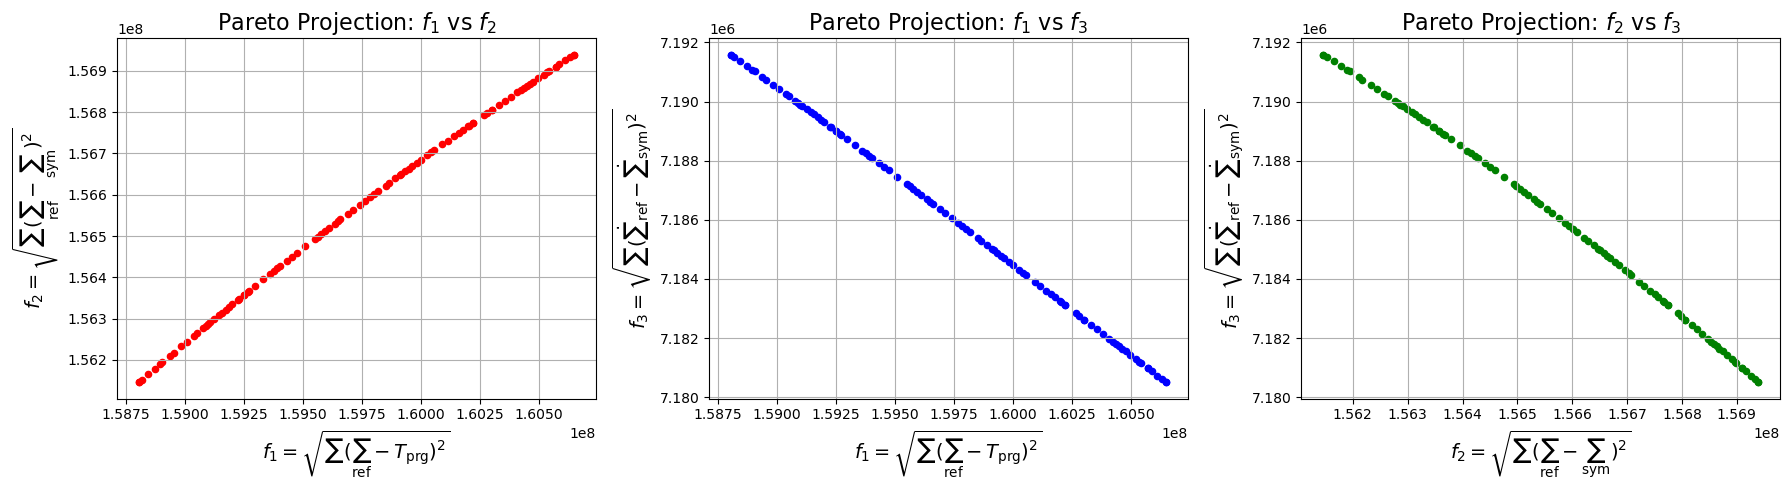

In [2]:
import matplotlib.pyplot as plt

# Построение 1x3 подграфиков: пары целей из F_res
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# f1 vs f2
axes[0].scatter(F_res[:, 0], F_res[:, 1], color='red', s=20)
axes[0].set_xlabel(r'$f_1 = \sqrt{\sum ( \sum_{\mathrm{ref}} - T_{\mathrm{prg}} )^2}$', fontsize=14)
axes[0].set_ylabel(r'$f_2 = \sqrt{\sum ( \sum_{\mathrm{ref}} - \sum_{\mathrm{sym}} )^2}$', fontsize=14)
axes[0].grid(True)
axes[0].set_title('Pareto Projection: $f_1$ vs $f_2$', fontsize=16)

# f1 vs f3
axes[1].scatter(F_res[:, 0], F_res[:, 2], color='blue', s=20)
axes[1].set_xlabel(r'$f_1 = \sqrt{\sum ( \sum_{\mathrm{ref}} - T_{\mathrm{prg}} )^2}$', fontsize=14)
axes[1].set_ylabel(r'$f_3 = \sqrt{\sum ( \dot{\sum}_{\mathrm{ref}} - \dot{\sum}_{\mathrm{sym}} )^2}$', fontsize=14)
axes[1].grid(True)
axes[1].set_title('Pareto Projection: $f_1$ vs $f_3$', fontsize=16)

# f2 vs f3
axes[2].scatter(F_res[:, 1], F_res[:, 2], color='green', s=20)
axes[2].set_xlabel(r'$f_2 = \sqrt{\sum ( \sum_{\mathrm{ref}} - \sum_{\mathrm{sym}} )^2}$', fontsize=14)
axes[2].set_ylabel(r'$f_3 = \sqrt{\sum ( \dot{\sum}_{\mathrm{ref}} - \dot{\sum}_{\mathrm{sym}} )^2}$', fontsize=14)
axes[2].grid(True)
axes[2].set_title('Pareto Projection: $f_2$ vs $f_3$', fontsize=16)

plt.tight_layout()
plt.show()


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |    100 |             - |             -
     2 |      200 |    100 |  0.0060244131 |             f
     3 |      300 |    100 |  0.0035724192 |         ideal
     4 |      400 |    100 |  0.0409646752 |         ideal
     5 |      500 |    100 |  0.0036158189 |             f
     6 |      600 |    100 |  0.0022120063 |             f
     7 |      700 |    100 |  0.0038734975 |             f
     8 |      800 |    100 |  0.0039533228 |         ideal
     9 |      900 |    100 |  0.0028035884 |             f
    10 |     1000 |    100 |  0.0014956174 |             f
    11 |     1100 |    100 |  0.0032787244 |             f
    12 |     1200 |    100 |  0.0025400925 |             f
    13 |     1300 |    100 |  0.0017647623 |             f
    14 |     1400 |    100 |  0.0031327226 |             f
    15 |     1500 |    100 |  0.0023373131 |             f
    16 |     1600 |    100 |  0.0035097903 |            

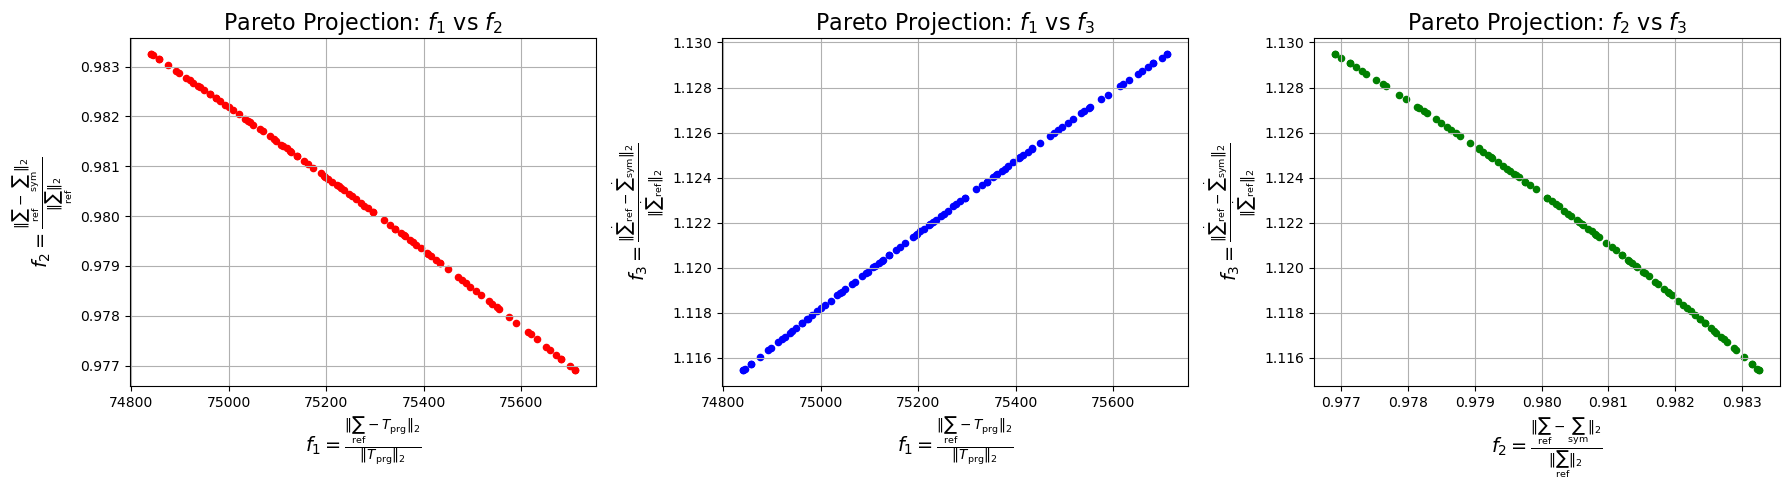

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

# ——————————————
# 1. ФИЗИЧЕСКИЕ ПАРАМЕТРЫ
# ——————————————
Q = 1000.0        # мощность теплового потока, Вт
F = 1.0           # коэффициент формы (безразмерный)
cp = 500.0        # суммарная теплоёмкость (c·ρ), Дж/(кг·K)
a = 1e-5          # теплопроводная диффузия, м²/с
b = 0.01          # коэффициент аттенюации, 1/с
L = 0.05          # шаг расположения «эталонных» источников, м
l = 0.02          # смещение для «симметричных» источников, м

# ——————————————
# 2. ВРЕМЕННЫЕ УЗЛЫ И ЭТАЛОННЫЙ ПРОФИЛЬ
# ——————————————
n_time = 50
t = np.linspace(1.0, 1000.0, n_time)  # интервал [1, 1000] с

# Эталонный профиль (300 K ± 10 K)
T_prg = 300.0 + 10.0 * np.sin(2 * np.pi * (t - 1) / (1000.0 - 1))

# Норма эталонного профиля для нормализации f1
norm_Tprg = np.linalg.norm(T_prg)

# ——————————————
# 3. «ЭТАЛОННЫЕ» И «СИММЕТРИЧНЫЕ» ИСТОЧНИКИ
# ——————————————
n_ref = 5
ref_indices = np.arange(n_ref)  # [0, 1, 2, 3, 4]

class ThermalParetoProblem(Problem):
    """
    Многокритериальная задача с тремя нормализованными целями:
      f1 = ||sum_ref - T_prg||₂ / ||T_prg||₂
      f2 = ||sum_ref - sum_sym||₂ / ||sum_ref||₂
      f3 = ||d_ref - d_sym||₂ / ||d_ref||₂

    Переменные: h и W (толщина и ширина) ∈ [0.001, 0.1] м.
    """
    def __init__(self):
        super().__init__(
            n_var=2,        # h и W
            n_obj=3,        # три целевые функции (нормализованные)
            n_constr=0,     # без дополнительных ограничений
            xl=np.array([0.001, 0.001]),  # min h, W
            xu=np.array([0.1,   0.1])     # max h, W
        )

    def _evaluate(self, X, out, *args, **kwargs):
        pop_size = X.shape[0]

        f1 = np.zeros(pop_size)
        f2 = np.zeros(pop_size)
        f3 = np.zeros(pop_size)

        for i in range(pop_size):
            h, W = X[i, 0], X[i, 1]

            # b_eff зависит от h
            b_eff = b * (1 + 0.5 * np.exp(-h / 0.01))

            # 1) вычисляем sum_ref(t)
            sum_ref = np.zeros_like(t)
            for k in ref_indices:
                dist_ref = 2 * k * L
                sum_ref += (
                    2 * Q * F * cp
                    / np.sqrt(4 * a * t)
                    * np.exp(-dist_ref**2 / (4 * a * t) - b_eff * t)
                )

            # 2) вычисляем sum_sym(t)
            sum_sym = np.zeros_like(t)
            for j in (-1, 1):
                dist_sym = j * l
                sum_sym += (
                    Q * F * cp
                    / np.sqrt(4 * a * t)
                    * np.exp(-dist_sym**2 / (4 * a * t) - b_eff * t)
                )

            # --- Норма sum_ref для нормализации f2 ---
            norm_sum_ref = np.linalg.norm(sum_ref)

            # 3) вычисляем производные d_ref и d_sym
            dt = t[1] - t[0]
            d_ref = np.diff(sum_ref) / dt
            d_sym = np.diff(sum_sym) / dt

            # Норма d_ref для нормализации f3
            norm_d_ref = np.linalg.norm(d_ref)

            # --- Целевая 1: f1 = ||sum_ref - T_prg||₂ / ||T_prg||₂ ---
            residual1 = sum_ref - T_prg
            f1[i] = np.linalg.norm(residual1) / norm_Tprg

            # --- Целевая 2: f2 = ||sum_ref - sum_sym||₂ / ||sum_ref||₂ ---
            residual2 = sum_ref - sum_sym
            # Проверка, чтобы norm_sum_ref не был нулем:
            f2[i] = np.linalg.norm(residual2) / (norm_sum_ref + 1e-12)

            # --- Целевая 3: f3 = ||d_ref - d_sym||₂ / ||d_ref||₂ ---
            residual3 = d_ref - d_sym
            # Проверка, чтобы norm_d_ref не был нулем:
            f3[i] = np.linalg.norm(residual3) / (norm_d_ref + 1e-12)

        out["F"] = np.column_stack([f1, f2, f3])


# ——————————————
# 4. МНОГОКРИТЕРИАЛЬНАЯ ОПТИМИЗАЦИЯ (NSGA-II)
# ——————————————
problem = ThermalParetoProblem()
algorithm = NSGA2(pop_size=100)

res = minimize(
    problem,
    algorithm,
    ("n_gen", 200),
    verbose=True,
    seed=42
)

# ——————————————
# 5. ИЗВЛЕЧЕНИЕ И ВИЗУАЛИЗАЦИЯ ФРОНТА ПАРЕТО
# ——————————————
F_res = res.F  # теперь нормализованные значения (m, 3)

# 2D-проекции фронта Парето в 1×3 подграфиках
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# f1 vs f2
axes[0].scatter(F_res[:, 0], F_res[:, 1], color='red', s=20)
axes[0].set_xlabel(r'$f_1 = \frac{\|\sum_{\mathrm{ref}} - T_{\mathrm{prg}}\|_2}{\|T_{\mathrm{prg}}\|_2}$', fontsize=14)
axes[0].set_ylabel(r'$f_2 = \frac{\|\sum_{\mathrm{ref}} - \sum_{\mathrm{sym}}\|_2}{\|\sum_{\mathrm{ref}}\|_2}$', fontsize=14)
axes[0].grid(True)
axes[0].set_title('Pareto Projection: $f_1$ vs $f_2$', fontsize=16)

# f1 vs f3
axes[1].scatter(F_res[:, 0], F_res[:, 2], color='blue', s=20)
axes[1].set_xlabel(r'$f_1 = \frac{\|\sum_{\mathrm{ref}} - T_{\mathrm{prg}}\|_2}{\|T_{\mathrm{prg}}\|_2}$', fontsize=14)
axes[1].set_ylabel(r'$f_3 = \frac{\|\dot{\sum}_{\mathrm{ref}} - \dot{\sum}_{\mathrm{sym}}\|_2}{\|\dot{\sum}_{\mathrm{ref}}\|_2}$', fontsize=14)
axes[1].grid(True)
axes[1].set_title('Pareto Projection: $f_1$ vs $f_3$', fontsize=16)

# f2 vs f3
axes[2].scatter(F_res[:, 1], F_res[:, 2], color='green', s=20)
axes[2].set_xlabel(r'$f_2 = \frac{\|\sum_{\mathrm{ref}} - \sum_{\mathrm{sym}}\|_2}{\|\sum_{\mathrm{ref}}\|_2}$', fontsize=14)
axes[2].set_ylabel(r'$f_3 = \frac{\|\dot{\sum}_{\mathrm{ref}} - \dot{\sum}_{\mathrm{sym}}\|_2}{\|\dot{\sum}_{\mathrm{ref}}\|_2}$', fontsize=14)
axes[2].grid(True)
axes[2].set_title('Pareto Projection: $f_2$ vs $f_3$', fontsize=16)

plt.tight_layout()
plt.show()


C:\Users\ivan\AppData\Local\Temp\ipykernel_5132\1696400716.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=16)


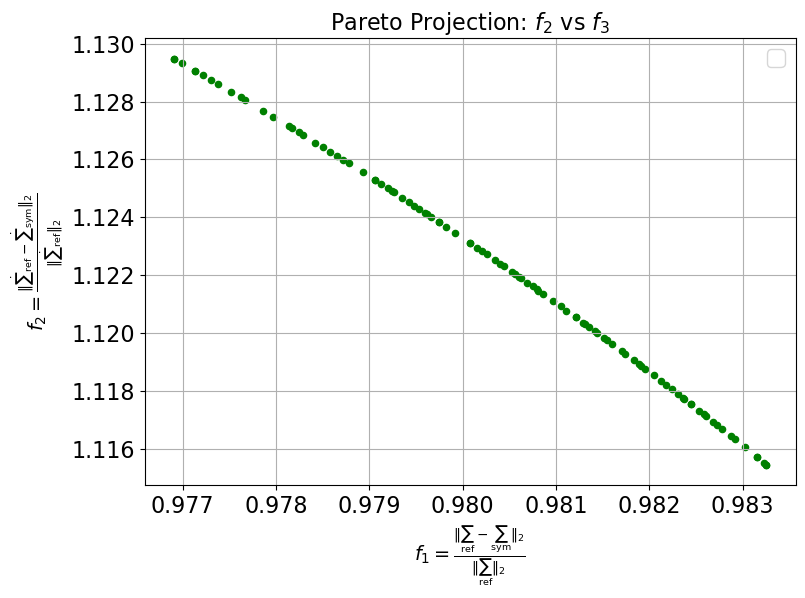

In [15]:
# Предположим, у вас уже есть массив F_res и построены оси axes[2].
# Чтобы сохранить только график axes[2] в PDF, можно создать новый отдельный рисунок 
# и заново отрисовать данные f2 vs f3, а затем сохранить этот рисунок.

import matplotlib.pyplot as plt

# 1. Извлекаем данные из F_res
f2_vals = F_res[:, 1]
f3_vals = F_res[:, 2]

# 2. Создаём новый фигур и ось
fig_single, ax_single = plt.subplots(figsize=(8, 6))

# 3. Строим scatter для f2 vs f3
ax_single.scatter(f2_vals, f3_vals, color='green', s=20)

# 4. Подписываем оси и задаём заголовок
ax_single.set_xlabel(
    r'$f_1 = \frac{\|\sum_{\mathrm{ref}} - \sum_{\mathrm{sym}}\|_2}{\|\sum_{\mathrm{ref}}\|_2}$', 
    fontsize=14
)
ax_single.set_ylabel(
    r'$f_2 = \frac{\|\dot{\sum}_{\mathrm{ref}} - \dot{\sum}_{\mathrm{sym}}\|_2}{\|\dot{\sum}_{\mathrm{ref}}\|_2}$', 
    fontsize=14
)
ax_single.set_title('Pareto Projection: $f_2$ vs $f_3$', fontsize=16)
ax_single.grid(True)

# 5. Опционально настроим отступы и тики
ax_single.tick_params(axis='both', which='major', labelsize=12)

# 6. Сохраняем в PDF
fig_single.tight_layout()
plt.legend(fontsize=16)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig_single.savefig('pareto_f2_vs_f3.pdf')

plt.show()  # Закрываем, если не хотим показывать на экране
